Example: Predicting the Molecular Type of Neurons
=================================================

To demonstrate some of the main functionalities of CAJAL,
here we perform some basic analysis on a set of neuron
morphological reconstructions obtained from the
[Allen Brain Atlas](https://celltypes.brain-map.org/). To facilitate
the analysis, we provide a compressed \*.tar.gz file containing the \*.SWC
files of 509 neurons used in this example, which can be downloaded directly from this
[link](https://www.dropbox.com/s/aq0ovetjtqihf4f/allen_brain_atlas_509_SWCs_mouse_full_or_dendrite_only.tar.gz?dl=0>).

For this analysis, we focus on the morphology of the dendrites and exclude the
axons of the neurons. To achieve this, we set `structure_ids = [1,3,4]`,
which tells CAJAL to only sample points from the soma and the basal and apical
dendrites. We sample 50 points from each neuron and compute the Euclidean distance
between each pair of points in that neuron using the following code:

In [1]:
import cajal.sample_swc
import cajal.swc

cajal.sample_swc.compute_icdm_all_euclidean(
    infolder="CAJAL/data/swc/",
    out_csv="CAJAL/data/swc_icdm.csv",
    preprocess=cajal.swc.preprocessor_eu(
        structure_ids=[1,3,4],
        soma_component_only=False),
    n_sample=50,
    num_cores=8)

[]

Once the sampling is completed, we compute the Gromov-Wasserstein distance
between each pair of neurons. To compute the Gromov-Wasserstein distance matrix we use
the code:

In [2]:
import cajal.run_gw

cajal.run_gw.compute_and_save_gw_distance_matrix(
    "CAJAL/data/swc_icdm.csv",
    "CAJAL/data/swc_gwm.csv",
    verbose = False)

1
101
201
301
401
501
Computation finished. Computed 129286 cell pairs. Time elapsed: 667.9789550304413


The computation will take 10-20 minutes in a standard desktop computer.

We can visualize the resulting space of cell morphologies using UMAP:

In [4]:
import cajal.utilities
import umap
import plotly.express
import plotly.io
from scipy.spatial.distance import squareform

# Read GW distance matrix
cells, gw_dist_dict = cajal.utilities.read_gw_dists("CAJAL/data/swc_gwm.csv", header=True)
gw_dist_vec = cajal.utilities.dist_mat_of_dict(gw_dist_dict)
gw_dist = squareform(gw_dist_vec)

# Compute UMAP representation
reducer = umap.UMAP(metric="precomputed", random_state=1)
embedding = reducer.fit_transform(gw_dist)

# Visualize UMAP
plotly.io.renderers.default = 'iframe'
plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells])

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning:

using precomputed metric; inverse_transform will be unavailable



We can use the Leiden algorithm to cluster the neurons based on their morphology:

In [5]:
clusters = cajal.utilities.leiden_clustering(gw_dist, seed=1)
plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells],
                       color = [str(m) for m in clusters])

As expected, cells belonging to the same cluster have similar morphology. For example,
let us visualize some of the cells in the pink cluster (cluster 14) using the Python package [NAVis](https://navis.readthedocs.io/en/latest/index.html>):

(<Figure size 720x720 with 1 Axes>, <Axes3DSubplot: >)

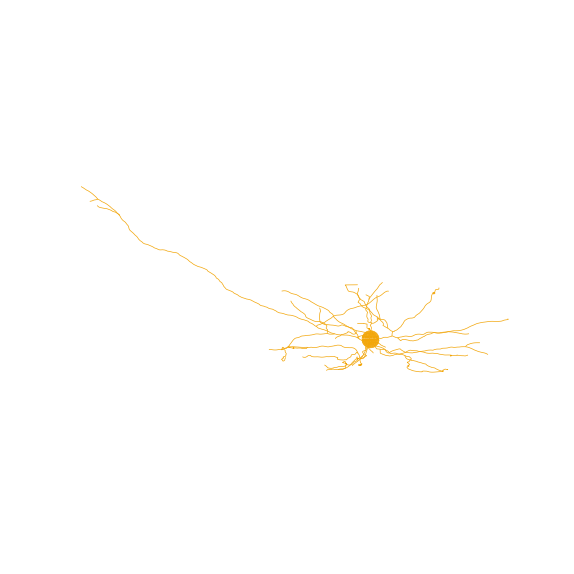

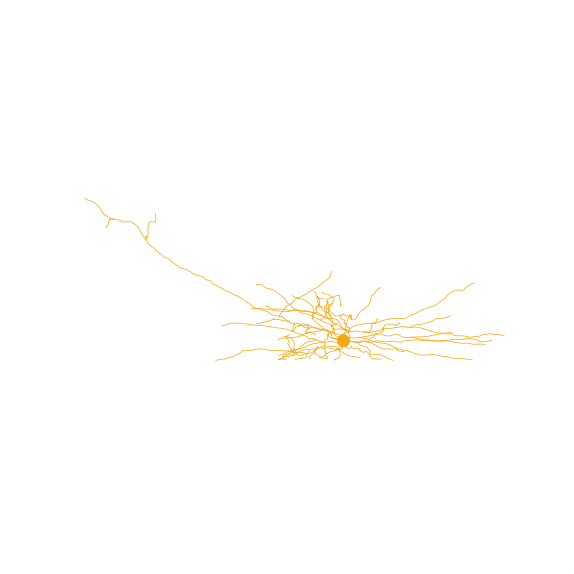

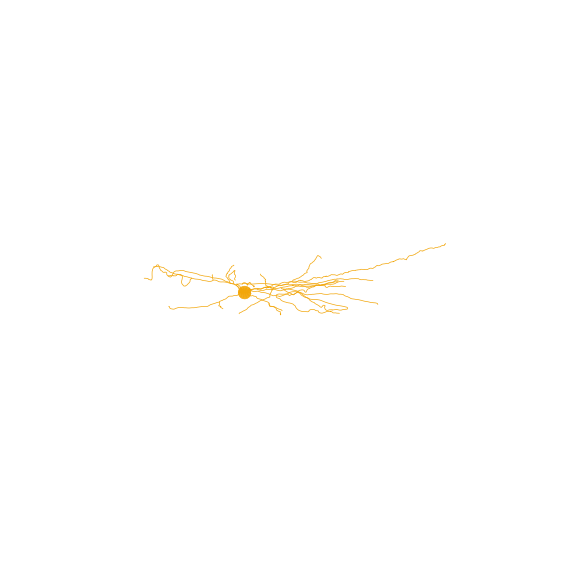

In [15]:
import navis

cells_cluster_14 = [n for m, n in zip(clusters, cells) if m==14]
cluster_14 = [navis.read_swc("CAJAL/data/swc/" + n + ".swc") for n in cells_cluster_14]

cluster_14[1].plot2d()
cluster_14[2].plot2d()
cluster_14[3].plot2d()

We can also compute the medoid of the cluster, i. e. the most central
neuron of the cluster (and therefore a good representative of the
morphologies present in the cluster), and visualize it:

(<Figure size 720x720 with 1 Axes>, <Axes3DSubplot: >)

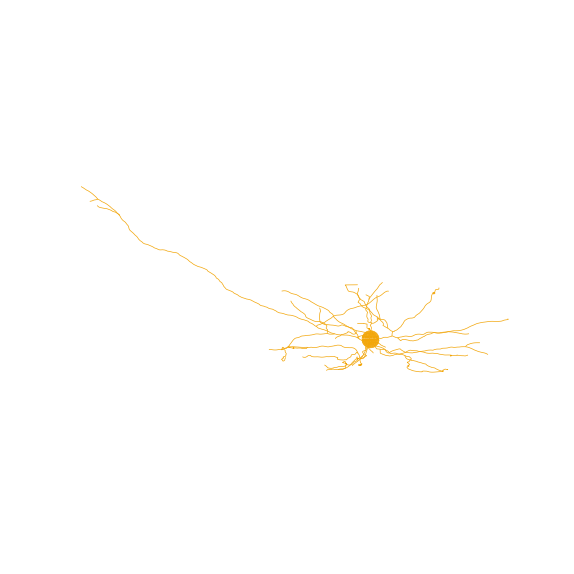

In [8]:
medoid = navis.read_swc("CAJAL/data/swc/" + 
                        cajal.utilities.identify_medoid(cells_cluster_14, gw_dist_dict) + 
                        ".swc")
medoid.plot2d()

The file ``CAJAL/data/cell_types_specimen_details.csv`` in the GitHub repository of CAJAL
contains metadata for each of the neurons in this example, including the layer, Cre line, etc.
Here we color the above UMAP representation by the cortical layer of each neuron:

In [9]:
import pandas

metadata = pandas.read_csv("CAJAL/data/cell_types_specimen_details.csv")
metadata.index = [str(m) for m in metadata["specimen__id"]]
metadata = metadata.loc[cells]

plotly.express.scatter(x=embedding[:,0], 
                       y=embedding[:,1], 
                       template="simple_white", 
                       hover_name=[m + ".swc" for m in cells],
                       color = metadata["structure__layer"])

As shown in the visualization, different cortical layers seem to be
associated with specific regions of the cell morphology space. We can quantify
statistically the association using the Laplacian score:

In [11]:
import cajal.laplacian_score
import numpy
import pandas

# Build indicator matrix
layers = numpy.unique(metadata["structure__layer"])
indicator = (numpy.array(metadata["structure__layer"])[:,None] == layers)*1

# Compute the Laplacian score
laplacian = pandas.DataFrame(cajal.laplacian_score.laplacian_scores(indicator, 
                                       gw_dist_vec, 
                                       numpy.median(gw_dist_vec), 
                                       permutations = 5000, 
                                       covariates = None, 
                                       return_random_laplacians = False)[0])
laplacian.index = layers

print(laplacian)

     feature_laplacians  laplacian_p_values  laplacian_q_values
1              0.972273              0.0006            0.001028
2/3            0.968339              0.0002            0.000800
4              0.966987              0.0002            0.000800
5              0.984843              0.0006            0.001028
6a             0.988970              0.0014            0.001680
6b             0.988682              0.0024            0.002400


We observe that indeed all cortical layers are significantly associated with distinct
regions of the cell morphology space with false discovery rates (FDRs) < 0.05.

We could perform a similar analysis with other features. Alternatively, we could
build a classifier to predict the value of each feature based on the position of the cells in
the cell morphology space. For example, each neuron in the dataset is derived
from a specific Cre driver line, which preferentially labels distinct neuronal types.
Neurons from the same Cre driver line therefore tend to have similar morphologies, and
a Laplacian score analysis would show that many Cre driver lines are significantly
associated with distinct regions of the cell morphology space. As a result, it is
possible to predict the Cre driver line of a neuron based on its morphological features.

To accomplish this, we train a nearest-neighbors classifier on the GW distance matrix and
evaluate its accuracy using 7-fold cross-validation:

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

cre_lines = numpy.array(metadata["line_name"])

clf = KNeighborsClassifier(metric="precomputed", n_neighbors=10, weights="distance")
cv = StratifiedKFold(n_splits=7, shuffle=True)
accuracy = cross_val_score(clf, X=gw_dist, y=cre_lines,cv=cv)

numpy.mean(accuracy)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=7.



0.2768808436616656

Similarly, we can compute the
[Matthews correlation coefficient](https://bmcgenomics.biomedcentral.com/counter/pdf/10.1186/s12864-019-6413-7.pdf) 
of the classification, which appropriately weights the error arising from misclassifying
elements of smaller classes:

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import matthews_corrcoef

cvp = cross_val_predict(clf, X=gw_dist, y=cre_lines, cv=cv)

print(matthews_corrcoef(cvp, cre_lines))

0.22431797648259547


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=7.

